In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys  
import os
import subprocess
from cpymad.madx import Madx
from cpymad import libmadx
import subprocess
import matplotlib as mpl
from mpl_toolkits import mplot3d
from cpymad.types import Constraint
import ipywidgets as widgets
from scipy.optimize import minimize

import matplotlib.patches as patches


import json

import xtrack as xt
import xobjects as xo
import xpart as xp

In [2]:
def make_a_patch(row, ax, s_offset):
    if 'quadrupole' in row['element_type'].lower():
        _ = ax.add_patch(
            mpl.patches.Rectangle(
                (row['min_s']+s_offset, 0), row['max_s'] - row['min_s'], np.sign(row['k1l']), facecolor="k", edgecolor="k"
            )
        )
    elif 'sextupole' in row['element_type'].lower():
        _ = ax.add_patch(
            mpl.patches.Rectangle(
                (row['min_s']+s_offset, -1), row['max_s'] - row['min_s'], 2, facecolor="purple", edgecolor="purple"
            )
        )
    elif 'bend' in row['element_type'].lower():
        _ = ax.add_patch(
            mpl.patches.Rectangle(
                (row['min_s']+s_offset, -1), row['max_s'] - row['min_s'], 2, facecolor='white', edgecolor="red"
            )
        )

def draw_synoptic(ax, line_df, s_offset=0):
    # grouping thin elements    
    thickned_element_df = (
        line_df[~line_df['parent_name'].isnull()]
        .groupby('parent_name', as_index=False)
        .agg(min_s=('s','min'), max_s=('s','max'), 
            k0l=('k0l', 'sum'), k1l=('k1l', 'sum'),
            element_type=('element_type', lambda x: ','.join(x.unique())))
        .rename(columns={'parent_name': 'name'})
    )

    thickned_element_df.apply(lambda row: make_a_patch(row, ax, s_offset), axis=1)
    return thickned_element_df


def plot_twiss(fig, line : xt.Line, twiss : xt.TwissTable, keywords_to_label = 'quadrupole|bend', s_offset=0, plot_dispersion=True):
    gs = mpl.gridspec.GridSpec(4, 1, height_ratios=[1, 4, 4, 4])
    ax1 = fig.add_subplot(gs[0])  # Synoptic
    ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Beta functions
    ax3 = fig.add_subplot(gs[2], sharex=ax1)  # Dispersion functions
    ax4 = fig.add_subplot(gs[3], sharex=ax1)  # Phase advances (mux, muy)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    # Synoptic plot
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0+s_offset, twiss['s'].max()+s_offset], [0, 0], 'k-')

    line_df = line.get_table(attr=True).to_pandas()
    line_df = line_df[(line_df['s'] >= twiss.s[0]) & (line_df['s'] <= twiss.s[-1])]
    fig.thickned_element_df = draw_synoptic(ax1, line_df, s_offset=s_offset)

    # Beta functions plot
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s']+s_offset, twiss['betx'], 'r-', label=r'$\beta_x$')
    ax2.plot(twiss['s']+s_offset, twiss['bety'], 'b-', label=r'$\beta_y$')    
    ax2.legend()
    ax2.tick_params(axis='y')

    if plot_dispersion:
        # Dispersion functions plot
        ax3.set_ylabel('D (m)')
        ax3.plot(twiss['s']+s_offset, twiss['dx'], 'r--', label=r'$D_x$')
        ax3.plot(twiss['s']+s_offset, twiss['dy'], 'b--', label=r'$D_y$')
        ax3.legend()

    # Phase advances plot
    ax4.set_ylabel('Phase Advance (rad)')
    ax4.plot(twiss['s']+s_offset, twiss['mux'], 'r-', label=r'$\mu_x$')
    ax4.plot(twiss['s']+s_offset, twiss['muy'], 'b-', label=r'$\mu_y$')
    ax4.legend()
    ax4.set_xlabel('s (m)')

    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1.sharex(axnames)

    if keywords_to_label is not None:
        element_df_to_label = fig.thickned_element_df[fig.thickned_element_df['element_type'].str.contains(keywords_to_label, case=False)]
        ticks = (element_df_to_label['min_s']+s_offset).to_list()
        ticks_labels = element_df_to_label['name'].to_list()
    else:
        ticks, ticks_labels = [], []
    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=90)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min()+s_offset, twiss['s'].max()+s_offset)
    ax3.set_ylim(-2, 1)


sigma = lambda eps, dpp, beta, d, N=1 : N*np.sqrt(eps*beta + (d*dpp)**2)  

In [3]:
line = xt.Line.from_json('/home/gnigrell/WorkDir/lines_colldb/FCCee_z_V25.1_GHC_thin_tapered_2.1pm_TCT_at_TCS_settings.json')
tab = line.get_table()
# Place markers at the beggining and end of straight section fo injection PB 
line.insert_element(name="start_lss_2", element=xt.Marker(), at_s=tab['s', "ip.7"] + 10286.855722259006, s_tol=1e-3)
tab = line.get_table()
start_llss_2 = tab['s', "start_lss_2"]
end_llss_2 = start_llss_2+2032
line.insert_element(name="end_lss_2", element=xt.Marker(), at_s=end_llss_2 ,s_tol=1e-3)
line.build_tracker()
twiss = line.twiss()
twiss_df = twiss.to_pandas()


Loading line from dict:   0%|          | 0/201815 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/201807 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/201809 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


b6d38249a1314842b5a8bdc46123915b.c: In function ‘synrad_emit_photons.part.0.isra’:
b6d38249a1314842b5a8bdc46123915b.c:12253:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12253 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
b6d38249a1314842b5a8bdc46123915b.c:12213:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
b6d38249a1314842b5a8bdc46123915b.c:12198:16: note: ‘exact’ was declared here
12198 |   double appr, exact, result;
      |                ^~~~~
b6d38249a1314842b5a8bdc46123915b.c:12213:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


d103e330be19448ba3c4c8a4e11e8df6.c: In function ‘synrad_emit_photons.part.0.isra’:
d103e330be19448ba3c4c8a4e11e8df6.c:12254:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12254 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
d103e330be19448ba3c4c8a4e11e8df6.c:12214:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
d103e330be19448ba3c4c8a4e11e8df6.c:12199:16: note: ‘exact’ was declared here
12199 |   double appr, exact, result;
      |                ^~~~~
d103e330be19448ba3c4c8a4e11e8df6.c:12214:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.


In [4]:
# Insert septa1 where marker finj.4 is located
tab = line.get_table()
septa_location_s = tab['s','finj.4']
line.insert_element(name="septa1.b1", element=xt.Marker(), at_s=septa_location_s, s_tol=1e-3)
print(f"Septa 1 placed at s = {septa_location_s} m")
line.insert_element(name="septa2.b1", element=xt.Marker(), at_s=septa_location_s - 40, s_tol=1e-3)


Septa 1 placed at s = 79932.52827859562 m


Slicing line:   0%|          | 0/201812 [00:00<?, ?it/s]

<Line  at 140079569950464>

In [ ]:
possible_locations_kick1 = twiss_df[
    (twiss_df['s'] > (start_llss_2 + (2032 / 2))) &  # Small range around quadrupole
    (twiss_df['s'] < (septa_location_s))&
    (twiss_df['name'].str.contains('drift'))
]

possible_locations_kick2 = twiss_df[
    (twiss_df['s'] < (end_llss_2+50)) &  # Small range around quadrupole
    (twiss_df['s'] > (septa_location_s+20)) &
    (twiss_df['name'].str.contains('drift'))
]
possible_locations_kick1[ possible_locations_kick1['betx'] == possible_locations_kick1['betx'].min()][['name','betx', 'dx', 'mux', 's']] # 178194	drift_56817	39.910676	-0.264787	189.293271	79806.557263
possible_locations_kick2[possible_locations_kick2['betx'] == possible_locations_kick2['betx'].min()][['name','betx', 'dx', 'mux', 's']]  # 178292	drift_56850..0	180.132109	-0.502968	189.4827	80138.658247
#possible_locations_kick1[(possible_locations_kick1['mux'] > 188.9883) & (possible_locations_kick1['mux'] < 189.294)][['name','betx', 'dx', 'mux', 's']]
#possible_locations_kick2[(possible_locations_kick2['mux'] > 189.4823) & (possible_locations_kick2['mux'] < 189.625)][['name','betx', 'dx', 'mux', 's']]

In [ ]:
# Find the minimum of betax between the center of lss and the septa location 
possible_locations = twiss_df[
    (twiss_df['s'] > (start_llss_2 + (2032 / 2))) &  # Small range around quadrupole
    (twiss_df['s'] < (septa_location_s))&
    (twiss_df['name'].str.contains('drift'))
]
possible_locations_kick2 = twiss_df[
    (twiss_df['s'] < (end_llss_2+50)) &  # Small range around quadrupole
    (twiss_df['s'] > (septa_location_s+20)) &
    (twiss_df['name'].str.contains('drift'))
]

betx_min_location = possible_locations[possible_locations['betx'] == possible_locations['betx'].min()]

if not betx_min_location.empty:
    
    mux_temp = twiss_df.loc[twiss_df['s'] == betx_min_location['s'].values[0], 'mux'].values[0]

    max_phase_advance = max(mux_temp - possible_locations_kick2['mux'])
    
    if max_phase_advance > 0.5:
        print(f"First kicker placed at s = {betx_min_location['s'].values[0]} m (min betax)")
        #line.insert_element(name="injection_kick_1", element=xt.Multipole(), at_s=min_dispersion_location_s-70, s_tol=1e-3)
    else:
        diff_mu_to_target = 0.5 - max_phase_advance
        possible_locations = possible_locations[possible_locations['']]

        
    # Insert the first kicker at the location with the minimum dispersion
    #line.insert_element(name="injection_kick_1", element=xt.Multipole(), at_s=min_dispersion_location_s-70, s_tol=1e-3)
    print(f"First kicker placed at s = {min_dispersion_location_s-70} m (min dispersion)")

else:
    print("No suitable location found for the first kicker with minimal dispersion.")

line.insert_element(name="injection_kick_2", element=xt.Multipole(), at_s=end_llss_2-110, s_tol=1e-3)
print(f"Second kicker placed at s = {end_llss_2-110} m")

Dispersion at kicker 1 location is: -0.264786956608974


Slicing line:   0%|          | 0/201334 [00:00<?, ?it/s]

First kicker placed at s = 79736.55726329198 m (min dispersion)


Slicing line:   0%|          | 0/201336 [00:00<?, ?it/s]

Second kicker placed at s = 80202.73750482645 m


In [ ]:
line.build_tracker()
twiss = line.twiss()
twiss_df = twiss.to_pandas()
#twiss_df[twiss_df['name'].str.contains('kick')][['name','mux','betx']]
#	name	s	x	px	y	py	zeta	delta	ptau	W_matrix	...	bx_chrom	by_chrom	ax_chrom	ay_chrom	wx_chrom	wy_chrom	ddx	ddpx	ddy	ddpy
#178192	injection_kick_1::0	79721.557263	-6.899749e-11	1.367048e-12	1.818431e-14	1.224396e-16	-0.000001	0.000104	0.000104	[[13.555649842335173, 9.459464624611038e-16, 3...	...	-49.984688	-67.454185	-18.399141	48.764843	53.263472	83.235071	1.618426	0.013198	0.000004	-2.655854e-09
#178194	injection_kick_1::1	79736.557263	-4.849390e-11	1.367048e-12	2.002071e-14	1.224396e-16	-0.000001	0.000104	0.000104	[[11.082119334000694, -1.6887212975628479e-15,...	...	-44.905383	-69.370528	-28.222878	45.917751	53.037951	83.190805	2.039319	0.013198	0.000004	-2.655854e-09
#178196	injection_kick_1::2	79756.557263	-2.115578e-11	1.367048e-12	2.246925e-14	1.224396e-16	-0.000001	0.000104	0.000104	[[8.078505382902044, -8.72980416122581e-16, 4....	...	-27.471202	-71.407900	-45.024168	42.569343	52.743177	83.133851	2.600511	0.013198	0.000004	-2.655854e-09

filtered_df = twiss_df[(twiss_df['s'] > septa_location_s) & (twiss_df['s'] < end_llss_2+100)]
phi_k1 = twiss_df[twiss_df['name'] == 'injection_kick_1::1'].mux.values[0]

filtered_df[(filtered_df['mux'] -phi_k1 < 0.58) & (filtered_df['mux'] -phi_k1 > 0.443)][['name','s','betx','mux']]
#(filtered_df['mux'] -phi_k1).unique()

In [30]:
# Rebuild the tracker after inserting the elements
line.build_tracker()

# Calculate the Twiss parameters again to check the new optics
twiss = line.twiss()
twiss_df = twiss.to_pandas()

Compiling ContextCpu kernels...


798acf96bbe94ccea4798a50874f3fae.c: In function ‘synrad_emit_photons.part.0.isra’:
798acf96bbe94ccea4798a50874f3fae.c:12253:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12253 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
798acf96bbe94ccea4798a50874f3fae.c:12213:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
798acf96bbe94ccea4798a50874f3fae.c:12198:16: note: ‘exact’ was declared here
12198 |   double appr, exact, result;
      |                ^~~~~
798acf96bbe94ccea4798a50874f3fae.c:12213:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


c54cf33219a44fb9be15ba55ae291f6b.c: In function ‘synrad_emit_photons.part.0.isra’:
c54cf33219a44fb9be15ba55ae291f6b.c:12254:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12254 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
c54cf33219a44fb9be15ba55ae291f6b.c:12214:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c54cf33219a44fb9be15ba55ae291f6b.c:12199:16: note: ‘exact’ was declared here
12199 |   double appr, exact, result;
      |                ^~~~~
c54cf33219a44fb9be15ba55ae291f6b.c:12214:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.


In [7]:
twiss_df[twiss_df['name'].str.contains('kick')][['name','s','mux','betx']]

,name,s,mux,betx
178192,injection_kick_1,79736.557263,189.039619,122.813369
178298,injection_kick_2,80202.737505,189.538847,190.914039


In [9]:
(twiss['mux', 'injection_kick_1'] - twiss['mux', 'injection_kick_2'])*2*180

-179.72191613632617

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
added patch injection_kick_1               at s=79736.56m
added patch septa1.b1                      at s=79932.53m
added patch injection_kick_2               at s=80202.74m


(-1200.0, 1200.0)

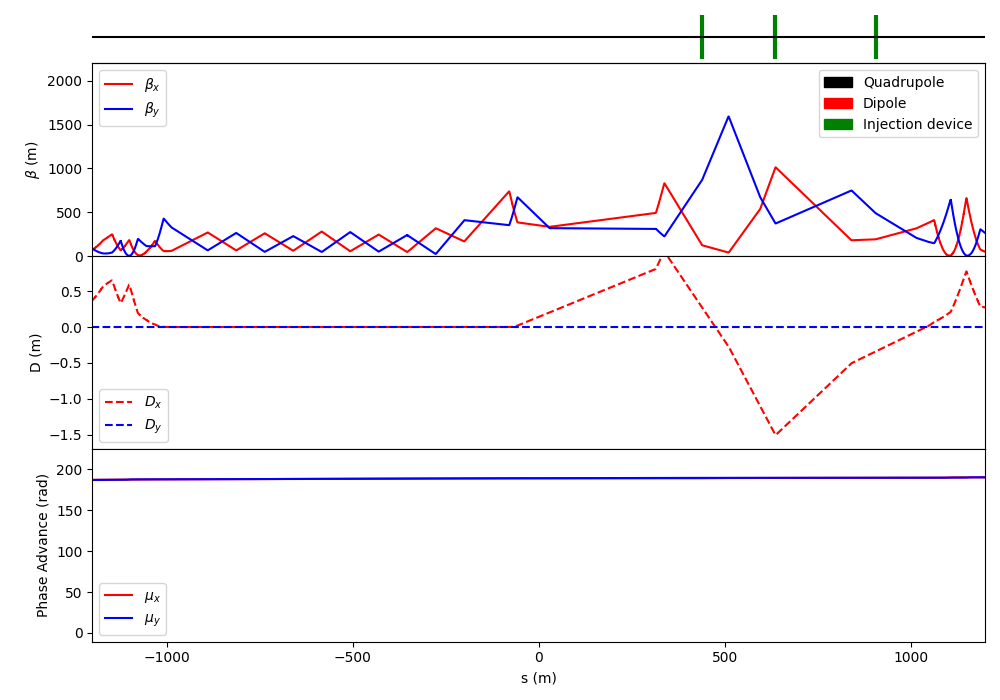

In [31]:
fig = plt.figure(figsize=(10,7))

s_offset = -twiss_df.loc[twiss_df['name'] == 'start_lss_2', 's'].values[0] - (2032 / 2)

plot_twiss(fig, line, twiss, keywords_to_label=None, s_offset=s_offset)


def add_patches_for_injection_devices(collider, fig, s_offset):
    collider_injection_elements_table = collider.get_table(attr=True).rows['injection_kick_1|injection_kick_2|septa1.b1']
    for i in range(len(collider_injection_elements_table)):
        el = collider_injection_elements_table.rows[i]
        fig.axes[0].add_patch(
            mpl.patches.Rectangle(
                (el.s.squeeze()+s_offset, -1), el.length.squeeze(), 2, facecolor='green', edgecolor="green", linewidth=3
            )
        )
        print(f'added patch {el.name[0]:30s} at s={el.s[0]:.2f}m')
add_patches_for_injection_devices(line, fig, s_offset)

l1= patches.Patch(facecolor="black", edgecolor="black", label="Quadrupole")
l2= patches.Patch(facecolor="red", edgecolor="red", label="Dipole")
l3= patches.Patch(facecolor="green", edgecolor="green", label="Injection device")

legend1 = fig.axes[1].legend(handles=fig.axes[1].lines, loc='upper left' )
fig.axes[1].add_artist(legend1)
fig.axes[1].legend(handles=[l1, l2, l3], loc='upper right')

fig.axes[1].set_ylim(0, 2200)
fig.axes[2].set_ylim(-1.7, 0.99)
fig.axes[1].set_xlim(-1200, 1200)


In [ ]:
# To have a correctly closed orbt bump the angle k2 must satify: k2 = sqrt(beta1/beta2) * k1
beta_1 = twiss['betx', 'injection_kick_1'] # whys this angle? to recah the 10 sigma max
beta_2 = twiss['betx', 'injection_kick_2']
theta_1 = 2.4e-5
theta_2 = theta_1 * (beta_2 / beta_1)

In [16]:
line['injection_kick_1'].knl = theta_1
line['injection_kick_2'].knl = theta_2 #3.457728093870607e-5


line.insert_element(name="injection_septa_kick", element=xt.Multipole(knl=[0]), at='septa1.b1')
line.insert_element(name="injection_septa2_kick", element=xt.Multipole(knl=[0]), at='septa2.b1')

In [21]:
line.insert_element(name="injection_dirft", element=xt.Marker(), at='septa1.b1::0')

septa1.b1


In [5]:
line.build_tracker()
twiss = line.twiss()
twiss_df = twiss.to_pandas()

The line already has an associated tracker


KeyboardInterrupt: 

In [13]:
line=xt.Line.from_json('/home/gnigrell/WorkDir/lines_colldb/FCCee_z_V25.1_GHC_thin_tapered_2.1pm_TCT_at_TCS_settings.json')
twiss = line.twiss()
p_co = twiss.particle_on_co
part = xp.build_particles(particle_ref=p_co, num_particles=5)
line.track(part,num_turns=3, turn_by_turn_monitor=True)
trajectory =  line.record_last_track

Loading line from dict:   0%|          | 0/201335 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...


a8293f33278b464396393246e935efd7.c: In function ‘synrad_emit_photons.part.0.isra’:
a8293f33278b464396393246e935efd7.c:12253:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12253 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
a8293f33278b464396393246e935efd7.c:12213:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
a8293f33278b464396393246e935efd7.c:12198:16: note: ‘exact’ was declared here
12198 |   double appr, exact, result;
      |                ^~~~~
a8293f33278b464396393246e935efd7.c:12213:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12213 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


7a9e19266d16479c89d6cacbb82f68e4.c: In function ‘synrad_emit_photons.part.0.isra’:
7a9e19266d16479c89d6cacbb82f68e4.c:12254:22: warning: ‘result’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12254 |         double const energy_loss = synrad_gen_photon_energy_normalized(part) * energy_critical; // eV
      |                      ^~~~~~~~~~~
7a9e19266d16479c89d6cacbb82f68e4.c:12214:18: warning: ‘exact’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in proportion of approx
      |            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7a9e19266d16479c89d6cacbb82f68e4.c:12199:16: note: ‘exact’ was declared here
12199 |   double appr, exact, result;
      |                ^~~~~
7a9e19266d16479c89d6cacbb82f68e4.c:12214:24: warning: ‘appr’ may be used uninitialized in this function [-Wmaybe-uninitialized]
12214 |   } while (exact < appr*RandomUniform_generate(part));  // reject in

Done compiling ContextCpu kernels.


In [17]:
len(trajectory.x.T)

3

In [18]:
from run_injecton_back import save_track_to_h5
save_track_to_h5(trajectory)

Data successfully saved to plots/merged_data_0.h5


In [4]:
def load_h5_to_dict(file_path):
    data_dict = {}
    
    with h5py.File(file_path, 'r') as h5f:
        for key in h5f.keys():
            # Load each dataset and store in the dictionary
            data_dict[key] = h5f[key][:]
    
    return data_dict
import h5py

In [5]:
dat = load_h5_to_dict('test_circulating_beam_3/merged_data_along_ring.h5')

In [6]:
len(dat['s'])

20

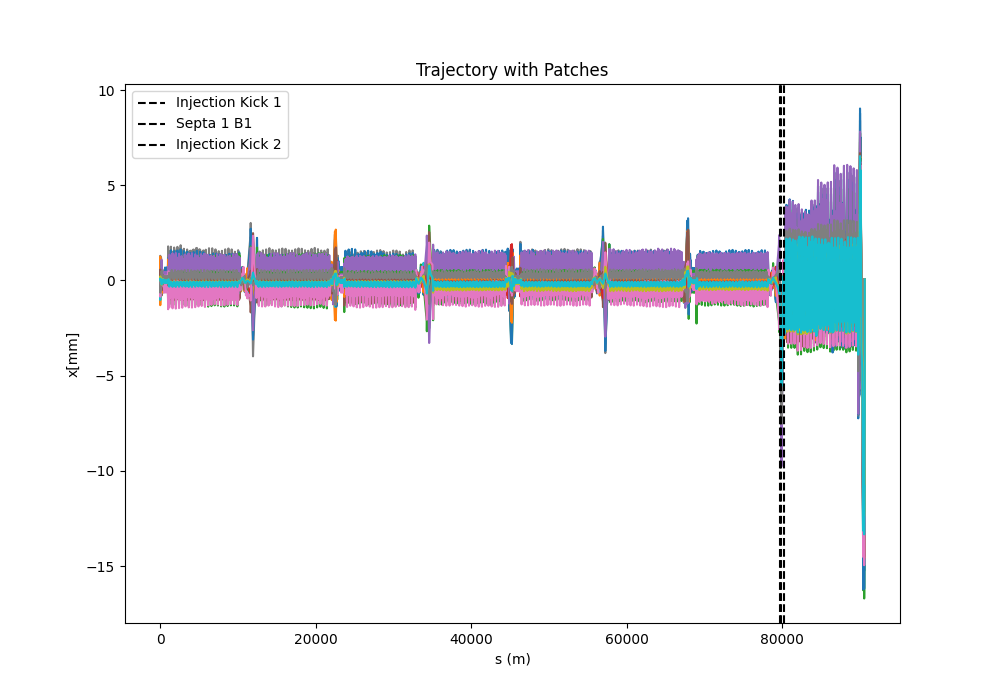

In [8]:
plt.figure(figsize=(10, 7))
trajectory = load_h5_to_dict('test_circulating_beam/merged_data_along_ring.h5')

for part in range(20):
    plt.plot(dat['s'][0], dat['x'][part]*1000)

# Add black vertical lines at specified positions
plt.axvline(x=79736.55726329198, color='black', linestyle='--', label='Injection Kick 1')
plt.axvline(x=79932.52827859562, color='black', linestyle='--', label='Septa 1 B1')
plt.axvline(x=80202.73750482645, color='black', linestyle='--', label='Injection Kick 2')

# Add legend
plt.legend()
plt.xlabel('s (m)')
plt.ylabel('x[mm]')
plt.title('Trajectory with Patches')
#plt.xlim(start_llss_2, start_llss_2 + 2032)
plt.show()

In [22]:
data_0 = load_h5_to_dict('test_circ_with_coll/merged_data_monitor_inject.h5')
data_1 = load_h5_to_dict('test_circ_with_coll/merged_data_monitor_kick1.h5')
data_2 = load_h5_to_dict('test_circ_with_coll/merged_data_monitor_kick2.h5')
data_3 = load_h5_to_dict('test_circ_with_coll/merged_data_monitor_prim_coll.h5')

In [20]:
len(data_0['x'].T)

50

/home/gnigrell/WorkDir/software/miniconda/miniconda3/envs/collimation/lib/python3.9/site-packages/ipympl/backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


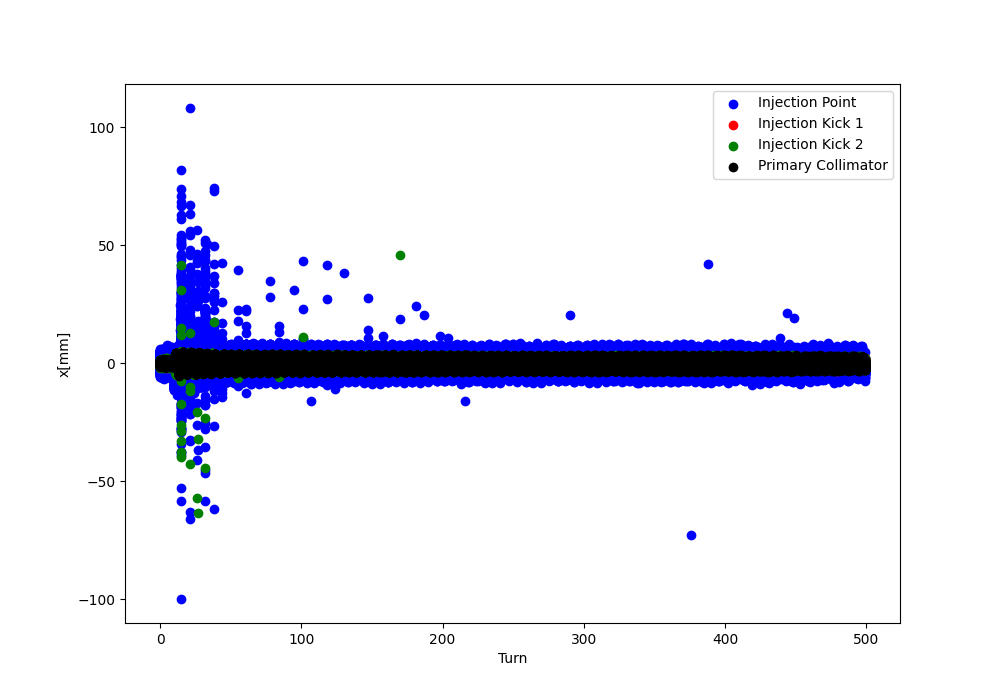

In [23]:
plt.figure(figsize=(10, 7))

plt.scatter(data_0['at_turn'], data_0['x']*1000, label='Injection Point', color='blue')
plt.scatter(data_1['at_turn'], data_1['x']*1000, label='Injection Kick 1', color='red') 
plt.scatter(data_2['at_turn'], data_2['x']*1000, label='Injection Kick 2', color='green')
plt.scatter(data_3['at_turn'], data_3['x']*1000, label='Primary Collimator', color='black')

# Add legend
plt.legend()
plt.xlabel('Turn')
plt.ylabel('x[mm]')

plt.show()